In [75]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt

#### Dataset taken from: https://www.kaggle.com/datasets/rafsunahmad/worldwide-male-and-female-height-factors

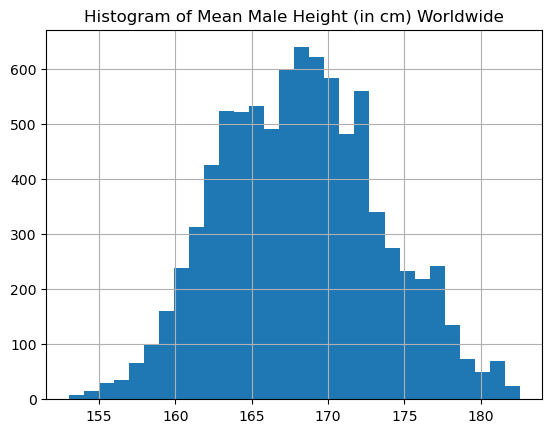

In [76]:
# Read the CSV 
df = pd.read_csv('annual-change-in-average-male-height.csv')
df = df.dropna(axis=0)

# Look at mean height of males
x = df['Mean male height (cm)'].values

df['Mean male height (cm)'].hist(bins=30)
plt.title('Histogram of Mean Male Height (in cm) Worldwide')

# Initialize Prior Hyperparameters, Mean and Precision
theta_0, tau = 167.5, 0.05
alpha, beta = 1, 1

# Initialize the normal_gamma_model
normal_gamma_model = pm.Model()
with normal_gamma_model:
    theta = pm.Normal("theta", mu=theta_0, sigma=tau)
    phi = pm.Gamma("phi", alpha=alpha, beta=beta)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=x)

#### Male heights are somewhat normally distributed, some transformations could be applied to the data to make it more 'normal'

In [77]:
with normal_gamma_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Split-Rhats {'theta': 1.0003, 'phi': 1.0012}


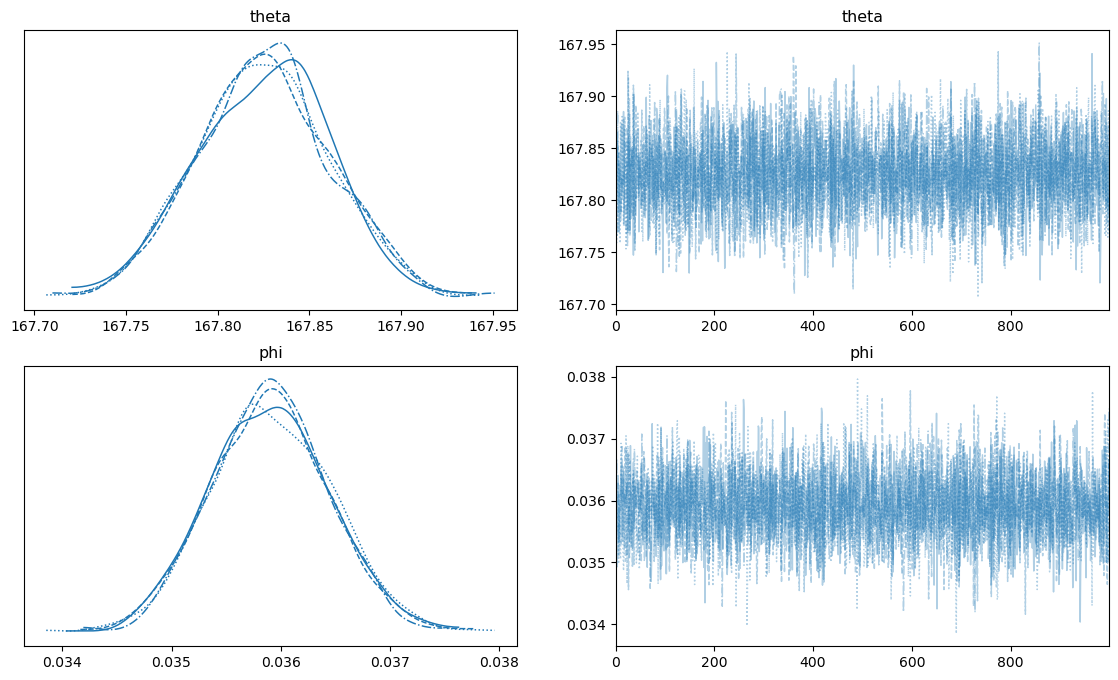

In [78]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,8))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
print("Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

#### R-hats are less than the threshold of 1.05, so we can say that the Markov Chain converges.

c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-pack

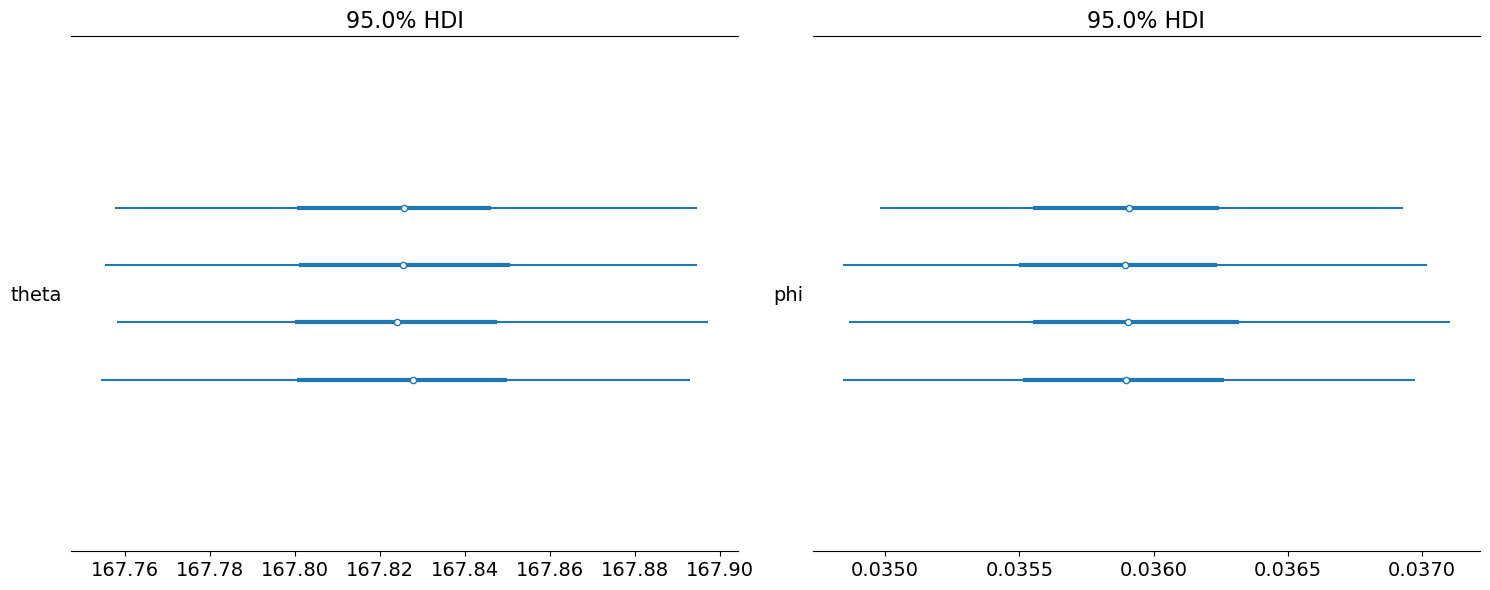

In [79]:
fig,ax = plt.subplots(1,2, figsize=(15,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1]);
plt.tight_layout()

#### High Density Intervals (95%) show the probability that each of the chains of parameters theta and phi (i.e. their values) lie within the specified interval.

#### We look at the "Daily caloric intake per person that comes from animal protein" column as a normal prior would not be appropriate. Instead of a normal-gamma specification, we choose a Weibnull-Exponential specification.

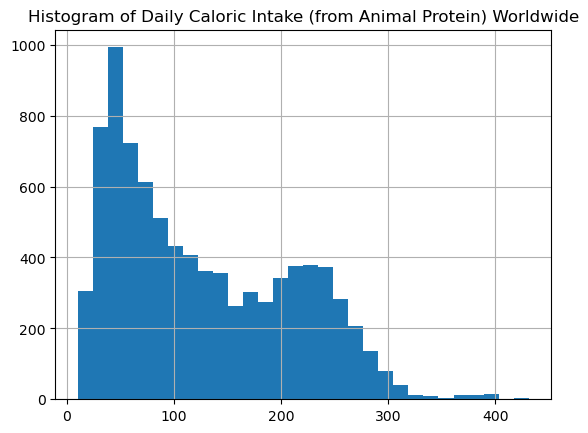

In [80]:
df['Daily caloric intake per person that comes from animal protein']

# Look at mean height of males
x = df['Daily caloric intake per person that comes from animal protein'].values

df['Daily caloric intake per person that comes from animal protein'].hist(bins=30)
plt.title('Histogram of Daily Caloric Intake (from Animal Protein) Worldwide')


weibull_model = pm.Model()

with weibull_model:
    # Priors for Weibull parameters
    alpha = pm.Exponential('alpha', 1.0)  # Shape parameter
    beta = pm.Exponential('beta', 1.0)    # Scale parameter
    
    # Weibull likelihood for the data
    data_likelihood = pm.Weibull('data', alpha=alpha, beta=beta, observed=x)

In [81]:
with weibull_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


HMC Split-Rhats {'alpha': 1.0004, 'beta': 1.0003}


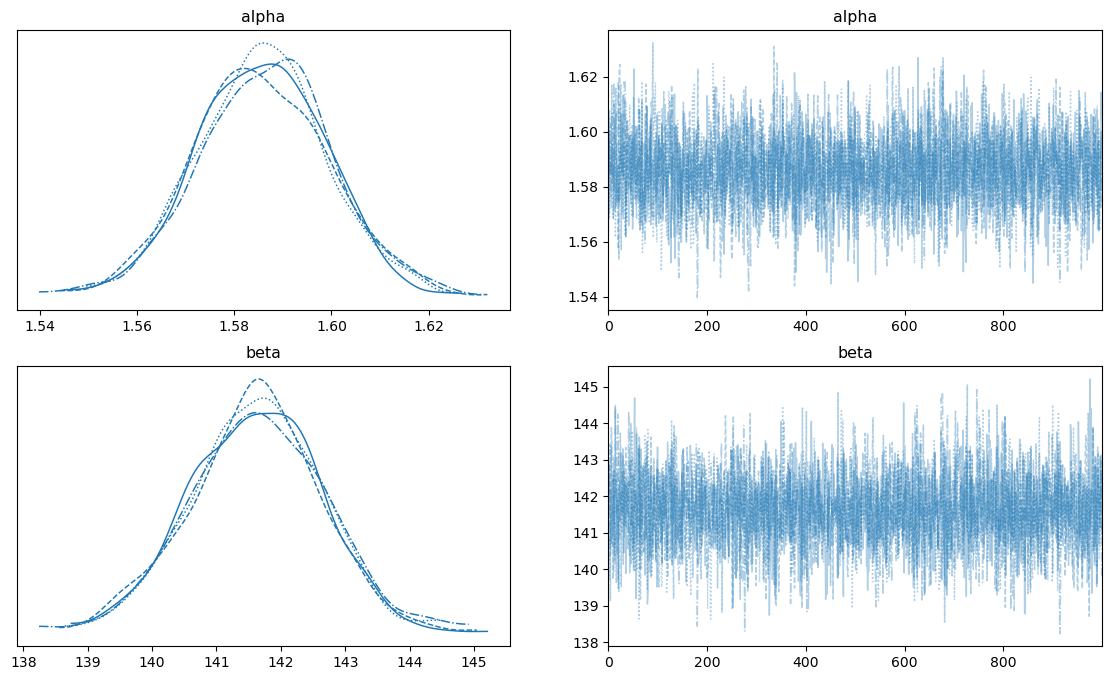

In [82]:
fig,ax = plt.subplots(2,2, figsize=(14,8))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

#### R-hat values are less than 1.05 which strongly implies the Markov Chain has converged

c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-pack

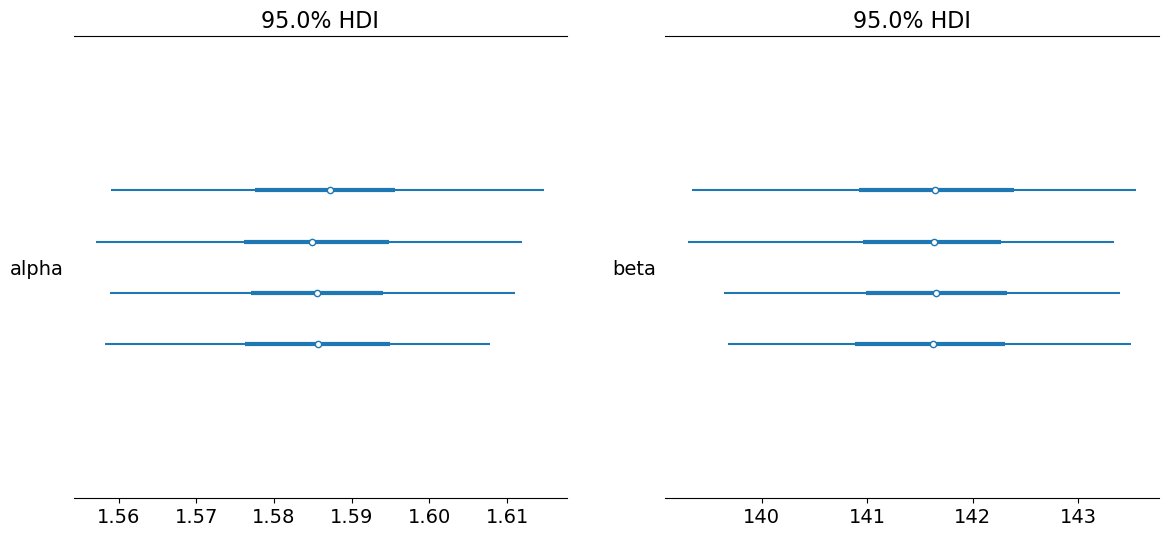

In [83]:
fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["alpha"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["beta"], combined=False, hdi_prob=0.95, ax=ax[1]);

#### We now look at the MCMC Chains w/ 100 samples and Autocorrelations of Generated Samples

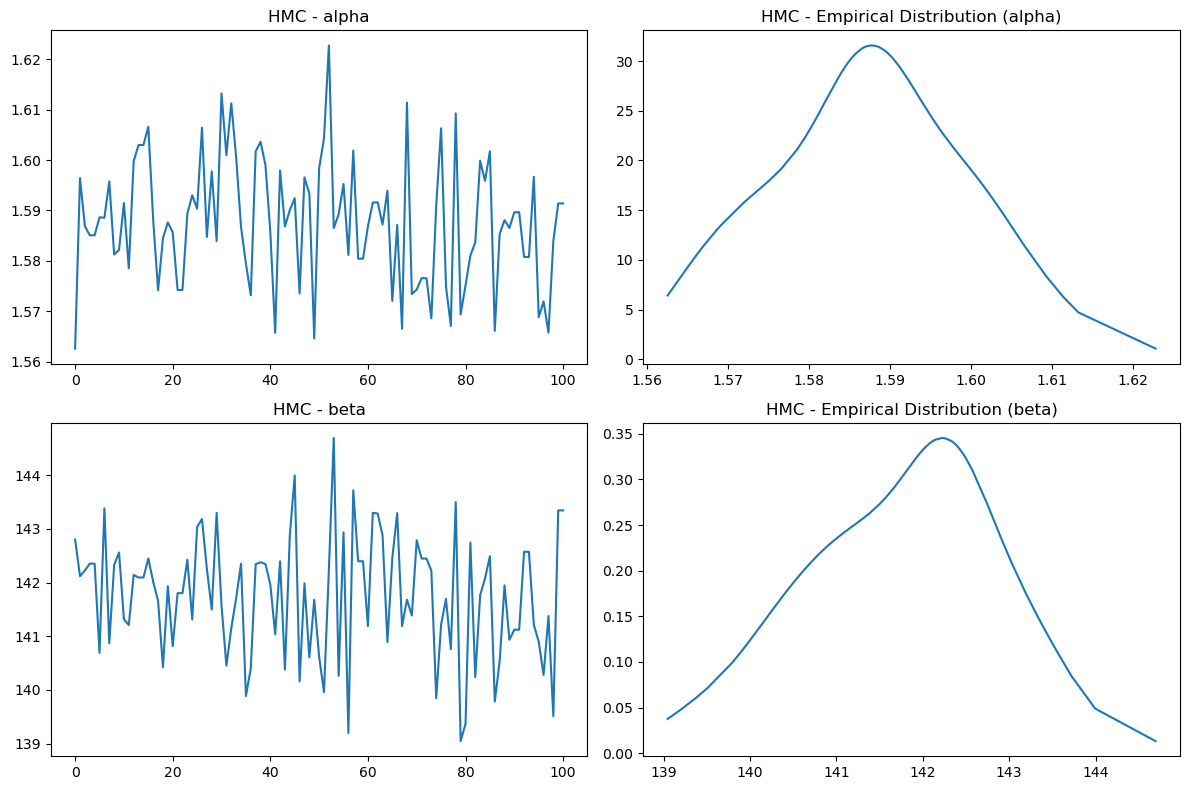

In [84]:
from scipy.stats import gaussian_kde

n_mcmc_samples = 100

# Create a figure with subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Loop over parameters "alpha" and "beta"
for i, parameter in enumerate(["alpha", "beta"]):
    # Extract MCMC samples
    mcmc_chain = idata_HMC.posterior[parameter].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
    mcmc_chain_sorted = sorted(mcmc_chain)

    # Plot raw MCMC samples
    ax[i, 0].plot(mcmc_chain)
    ax[i, 0].set_title(f"HMC - {parameter}")

    # Plot MCMC samples with empirical distribution
    ax[i, 1].plot(mcmc_chain_sorted, gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
    ax[i, 1].set_title(f"HMC - Empirical Distribution ({parameter})")

plt.tight_layout()
plt.show()

Autocorrelation for HMC (MCMC) chain - alpha: 0.06125520900740487
Autocorrelation for HMC (MCMC) chain - beta: 0.033940353105343074


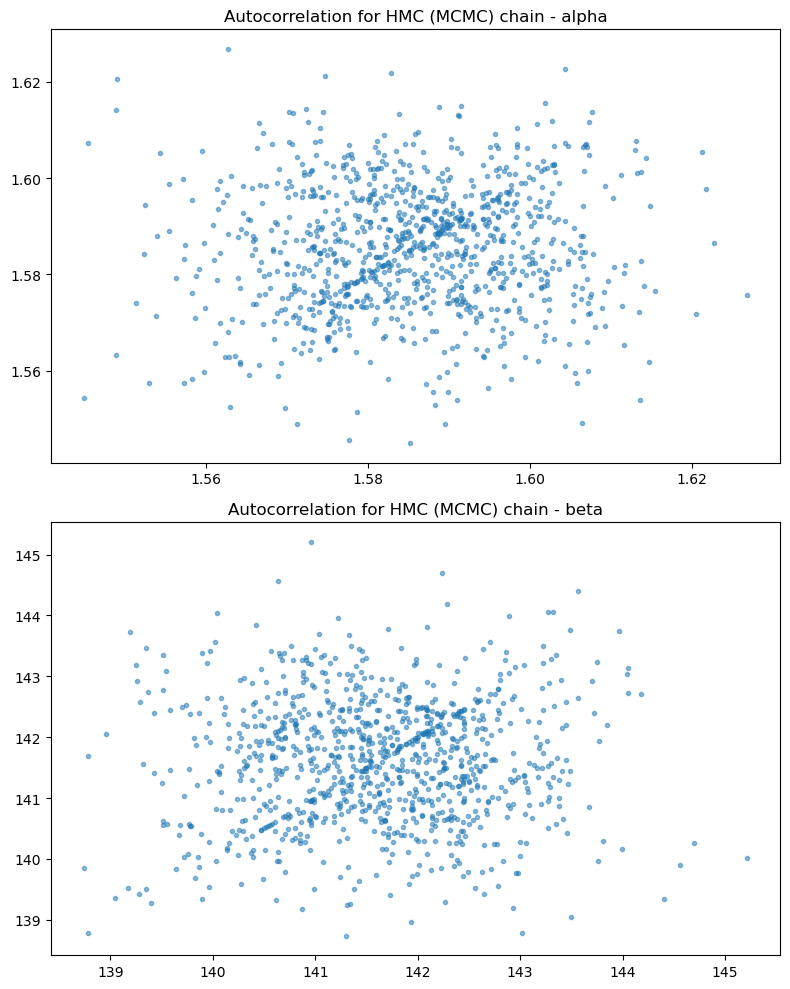

In [85]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Parameters
max_mcmc_samples = 1000
parameters = ["alpha", "beta"]

for i, parameter in enumerate(parameters):
    # Extract MCMC samples
    mcmc_chain = idata_HMC.posterior[parameter].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
    mcmc_chain_one_step_ahead = idata_HMC.posterior[parameter].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values

    # Plot autocorrelation
    ax[i].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
    ax[i].set_title(f"Autocorrelation for HMC (MCMC) chain - {parameter}")

    # Calculate and print autocorrelation
    autocorr = np.corrcoef(mcmc_chain, mcmc_chain_one_step_ahead)[0, 1]
    print(f"Autocorrelation for HMC (MCMC) chain - {parameter}: {autocorr}")

plt.tight_layout()
plt.show()

In [59]:
print("number of MCMC samples:", idata_HMC.posterior['alpha'].values.flatten().shape[-1])
print("number of MCMC samples:", idata_HMC.posterior['beta'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 4000
number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.59,0.01,1.56,1.61,0.00,0.00,3591.74,3033.55,1.0
beta,141.60,0.98,139.82,143.40,0.02,0.01,3575.25,2782.59,1.0


##### For both parameters alpha and beta, we plotted the autocorrelation between consecutive MCMC samples. With a maximum of 1000 samples considered, we observed very small autocorrelation for both parameters, with values around 0.05 and 0.0033 for alpha and beta chains respectively. These autocorrelation values are rather small, but we can still say that the MCMC chains sampled from this distribution are reliable. 

- The number of effective samples (ess_bulk) for alpha is approximately 3597.14, which is quite high relative to the total number of samples. This suggests that the samples are highly informative and there's a low level of autocorrelation affecting the chain.
- The number of effective tail samples (ess_tail) is approximately 3033.55, also indicating a good level of independence in the tail end of the MCMC distribution. This number is important for accurately estimating the tails of the posterior distribution.
- The ess_bulk for beta is around 3575.25, which again is a good proportion of the total number of samples, implying that the samples are similarly informative with a minimal impact from autocorrelation.
- The ess_tail is approximately 2782.59, which, while slightly lower than that for alpha, still represents a strong level of independence in the tail samples. This is indicative of the chain's ability to explore the tail regions of the posterior distribution effectively.